In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from misc import data
import seaborn as sns
sns.set_style('whitegrid')

## 1. Comparing 8, 16 and 32 latent size

In [2]:
def plot_spearman(file_list, labels=None, save_name=None, **kwargs):
    
    plt.figure(figsize=(10, 7))
    
    for i, file in enumerate(file_list):
        model_dict = torch.load(file)
        plt.plot(model_dict['stats']['cor'], lw=2, c=f'C{i}', label="Our result" if labels is None else labels[i])
    
    plt.title(r"$|Spearman\ \rho|$ correlation to experimental data", size=26)
    plt.xlabel('Epoch', size=24)
    plt.ylabel(r'Spearman Correlation $\rho$', size=24)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    if 'xlim' in kwargs.keys():
        plt.xlim(kwargs['xlim'])
        
    if 'ylim' in kwargs.keys():
        plt.ylim(kwargs['ylim'])
    
    plt.legend(prop={'size': 22})
    
    if save_name:
        plt.savefig(f'saved_figs/{save_name}.png', bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()

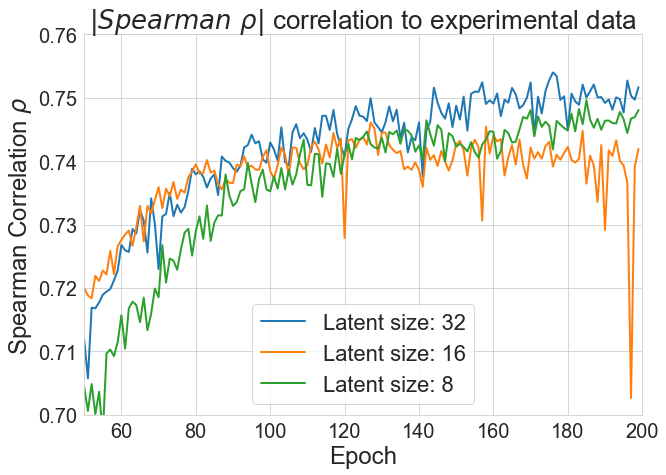

In [8]:
file_list = ['models/ep200_hs2000_e512_ls32.model.pth',
             'models/ep200_hs2000_e512_ls16.model.pth',
             'models/ep200_hs2000_e512_ls8.model.pth']
labels = ['Latent size: 32', 'Latent size: 16', 'Latent size: 8']

kwargs = {
    'xlim': (50, 200),
    'ylim': (0.70, 0.76)
}

plot_spearman(file_list, labels, 'latent_comparison', **kwargs)

## 2. Compare to VAE with dropout

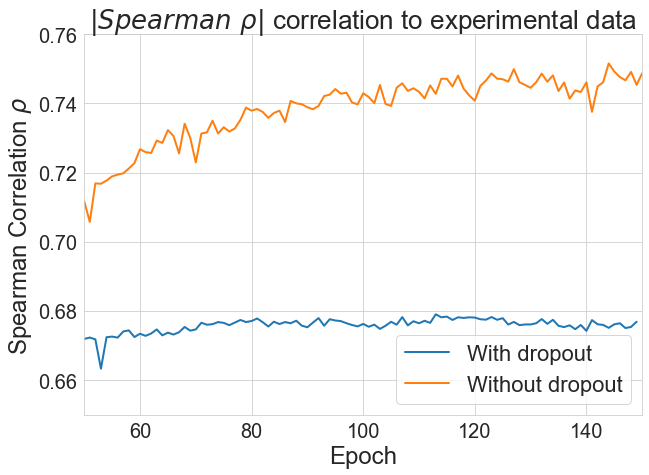

In [19]:
file_list = ['models\ep150_hs2000_e512_ls32_dropout.model.pth',
             'models\ep200_hs2000_e512_ls32.model.pth']
labels = ['With dropout', 'Without dropout']

kwargs = {
    'xlim': (50, 150),
    'ylim': (0.65, 0.76)
}

plot_spearman(file_list, labels, 'dropout_comparison', **kwargs)

## 3. Different init 

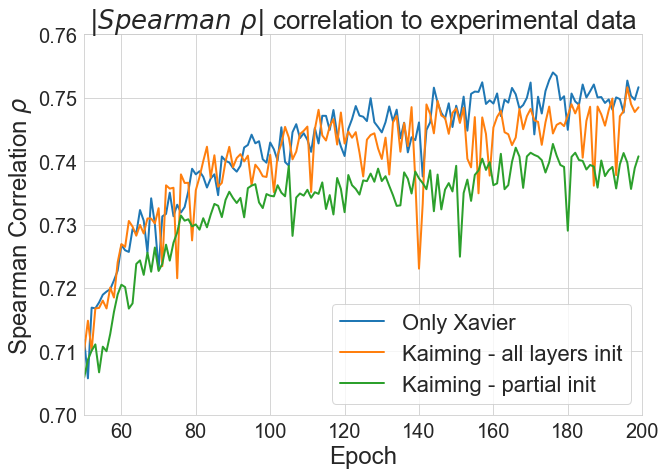

In [20]:
file_list = ['models\ep200_hs2000_e512_ls32.model.pth',
             'models\ep200_hs2000_e512_ls32_kaiming_allinit.model.pth',
             'models\ep200_hs2000_e512_ls32_kaiming_partialinit.model.pth']

labels=['Only Xavier',
        'Kaiming - all layers init', 
        'Kaiming - partial init']

kwargs = {
    'xlim': (50, 200),
    'ylim': (0.70, 0.76)
}

plot_spearman(file_list, labels, 'weight_init_comparison', **kwargs)

### Notes:
We see that it's important to initialize all layers, also group sparsity and latent space. 

For Kaiming you would normally set the bias to zero, but we don't do that in our models, as a zero bias init would focus on the KL and not the reconstruction.

So we see that it doesn't matter what kind of initialization we use (?)

## 4. Basic N-VAE vs Basic S-VAE

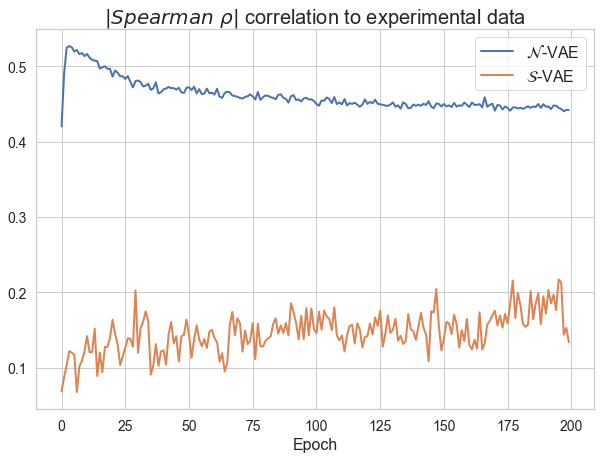

In [61]:
file_list = ['models\Basic_Nvae_ep200_hs64_ls2.model.pth', 
             'models\Basic_SVAE_ep200_hs64_ls2.model.pth']

labels = [r'$\mathcal{N}$-VAE', r'$\mathcal{S}$-VAE']

'''kwargs = {
    'xlim': (50, 200),
    'ylim': (0.70, 0.76)
}
'''

plot_spearman(file_list, labels)

### 4.1 Latent space representation

In [12]:
from vae_basic import Basic_VAE
from S_vae_basic import Basic_S_VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dict_N = torch.load('models\Basic_Nvae_ep200_hs64_ls2.model.pth')
dataloader_N, df_N, _, _ = data(weighted_sampling=False)

model_dict_S = torch.load('models\Basic_SVAE_ep200_hs64_ls2.model.pth')
dataloader_S, df_S, _, _ = data(device=device, weighted_sampling=False)

Parsing fasta 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105.a2m'
Parsing labels 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_LABELS.a2m'
Generating 8403 1-hot encodings
Generating 8403 1-hot encodings. Took 0.759s torch.Size([8403, 23, 253])
Dataset - Not weighted
Generating 4807 1-hot encodings
Generating 4807 1-hot encodings. Took 0.473s torch.Size([4807, 23, 253])
Parsing fasta 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105.a2m'
Parsing labels 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_LABELS.a2m'
Generating 8403 1-hot encodings
Generating 8403 1-hot encodings. Took 1.208s torch.Size([8403, 23, 253])
Dataset - Not weighted
Generating 4807 1-hot encodings
Generating 4807 1-hot encodings. Took 0.585s torch.Size([4807, 23, 253])


Size of latent space: 2


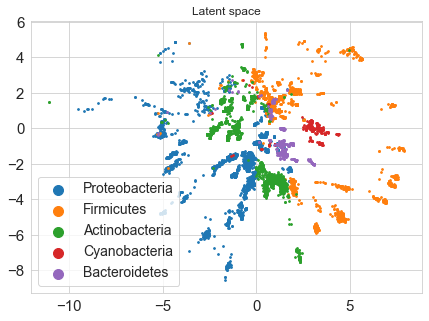

In [89]:
fig = plt.figure(figsize=(7, 5))

''' Normal latent space '''
ax1 = fig.add_subplot(111)
plt.title("Latent space")
mask = df_N['label'].isin(df_N['label'].value_counts()[:5].index) # We limit to top 5 classes only
vae = Basic_VAE(**model_dict_N['args'])
vae.load_state_dict(model_dict_N['state_dict'])
vae.eval()
_, mu, logvar = vae(dataloader_N.dataset[mask])
columns = [str(i+1) for i in range(mu.shape[1])] + ['label']

dfp = pd.DataFrame(data=np.c_[mu.detach().numpy(), df_N[mask]['label']], columns=columns)

for protein in dfp['label'].unique():
    label_filter = dfp['label'] == protein
    plt.scatter(dfp[label_filter]['1'], dfp[label_filter]['2'], s=3, label=protein)

plt.tick_params(axis='both', labelsize=15)
lgnd = plt.legend(loc="lower left", fontsize=14)
for l in lgnd.legendHandles:
    l._sizes = [100]

plt.show()

Size of latent space: 2
             1         2           label         z       lon       lat  \
0     0.858547 -0.512735  Proteobacteria  0.942447  0.960726 -0.504336   
1     0.595187 -0.803587      Firmicutes  0.903560  0.803569 -0.812617   
2     0.140895 -0.990025      Firmicutes  0.868172  0.239896 -1.034313   
3     0.721652 -0.692256      Firmicutes  0.920677  0.891445 -0.691047   
4     0.537602 -0.843199      Firmicutes  0.896767  0.754484 -0.857414   
...        ...       ...             ...       ...       ...       ...   
7683  0.105595 -0.994409  Actinobacteria  0.867232  0.181135 -1.039958   
7684  0.861741 -0.507349      Firmicutes  0.942994  0.962073 -0.498862   
7685  0.575030 -0.818132  Actinobacteria  0.901110  0.787078 -0.828957   
7686  0.306800 -0.951774  Actinobacteria  0.876156  0.491989 -0.986141   
7687  0.739199 -0.673487  Actinobacteria  0.923284  0.901695 -0.671064   

             x         y    r     theta  
0     0.766245 -0.518202  1.0 -0.538368  
1  

d:\github\variational-proteins\venv\lib\site-packages\torch\distributions\distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


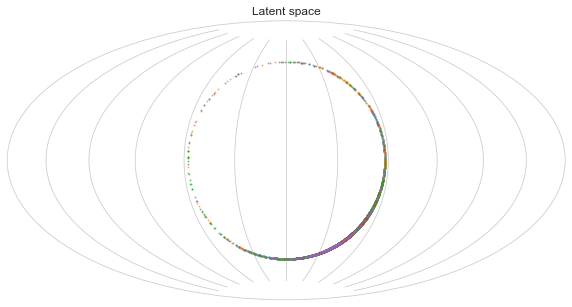

In [145]:
''' Hyperspherical plot '''
fig = plt.figure(figsize=(10, 7))
ax2 = fig.add_subplot(111, projection='hammer')
plt.title("Latent space")

mask = df_S['label'].isin(df_S['label'].value_counts()[:5].index) # We limit to top 5 classes only
vae = Basic_S_VAE(**model_dict_S['args']).to(device)
vae.load_state_dict(model_dict_S['state_dict'])
vae.eval()
_, mu, logvar, q_z, p_z = vae(dataloader_S.dataset[mask])
columns = [str(i+1) for i in range(mu.shape[1])] + ['label']

dfp = pd.DataFrame(data=np.c_[mu.detach().numpy(), df_S[mask]['label']], columns=columns)

#dfp['1'] = ax2.transData.transform(dfp['1'].values.astype('float'))
#dfp['2'] = ax2.transData.transform(dfp['2'].values.astype('float'))

#dfp = dfp.set_index('1').groupby('label')['2']
#dfp.plot(style='.', ms=2, alpha=0.5, legend=False)

dfp['1'] = dfp['1'].astype('float')
dfp['2'] = dfp['2'].astype('float')

dfp['z'] = np.sqrt(1-(1/4 * dfp['1'].values)**2 - (1/2 * dfp['2'].values)**2)
dfp['lon'] = 2*np.arctan((dfp['z'].values*dfp['1'].values)/(2*(2*dfp['z'].values**2 - 1)))
dfp['lat'] = np.arcsin(dfp['z'].values*dfp['2'].values)

lon = dfp['1'].values # x
lat = dfp['2'].values # y

dfp['x'] = (2*np.sqrt(2)*np.cos(lat)*np.sin(lon/2))/(np.sqrt(1 + np.cos(lat)*np.cos(lon/2)))
dfp['y'] = (np.sqrt(2)*np.sin(lat))/(np.sqrt(1 + np.cos(lat)*np.cos(lon/2)))

dfp['r'] = np.sqrt((dfp['1'].values**2 + dfp['2'].values**2))
dfp['theta'] = np.arctan(dfp['2'].values/dfp['1'].values)

print(dfp)

for protein in dfp['label'].unique():
    label_filter = dfp['label'] == protein
    ax2.scatter(dfp[label_filter]['lon'], dfp[label_filter]['lat'], s=1, alpha=0.5, label=protein)

plt.tick_params(
    axis='x',       # changes apply to both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

#plt.legend()
plt.yticks([])
plt.show()

Size of latent space: 2


d:\github\variational-proteins\venv\lib\site-packages\torch\distributions\distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


label
Actinobacteria    AxesSubplot(0.125,0.125;0.775x0.755)
Bacteroidetes     AxesSubplot(0.125,0.125;0.775x0.755)
Cyanobacteria     AxesSubplot(0.125,0.125;0.775x0.755)
Firmicutes        AxesSubplot(0.125,0.125;0.775x0.755)
Proteobacteria    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 2, dtype: object

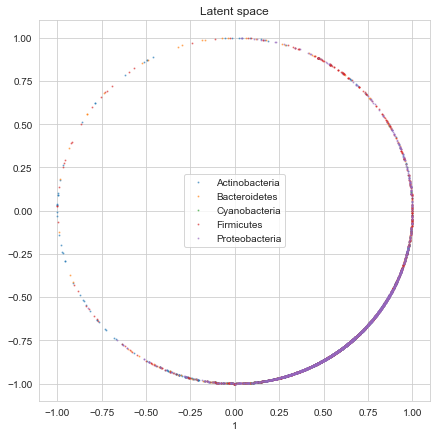

In [70]:
plt.figure(figsize=(7, 7))
plt.title("Latent space")
mask = df['label'].isin(df['label'].value_counts()[:5].index) # We limit to top 5 classes only
vae = Basic_S_VAE(**model_dict_S['args']).to(device)
vae.load_state_dict(model_dict_S['state_dict'])
vae.eval()
_, mu, logvar, q_z, p_z = vae(dataloader_S.dataset[mask])
columns = [str(i+1) for i in range(mu.shape[1])] + ['label']
dfp = pd.DataFrame(data=np.c_[mu.detach().numpy(), df[mask]['label']], columns=columns)
dfp = dfp.set_index('1').groupby('label')['2']
dfp.plot(style='.', ms=2, alpha=0.5, legend=True)